This notebook will look at the ellipses and the phase at the CODAR region.

In [77]:
import os
import datetime
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import csv
import pandas as pd
import subprocess as sp
from subprocess import Popen, PIPE
import matplotlib.colors as mcolors
import seaborn as sns
import scipy.io as sio

import netCDF4 as nc
from salishsea_tools import viz_tools, tidetools
from salishsea_tools.nowcast import research_VENUS

%matplotlib inline

In [78]:
thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)
grid = '/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
fB = nc.Dataset(grid)
bathy = fB.variables['Bathymetry'][:]
lons = fB.variables['nav_lon'][:]
lats = fB.variables['nav_lat'][:]

In [4]:
jmin = 379; jmax = 461; imin = 236; imax=321 
j = np.arange(jmin,jmax)
i = np.arange(imin,imax)

In [5]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 7, 13)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

count = np.arange(0,16)
params_av = np.zeros((898,398,8))

for x in i:
    for y in j:
        runname1 = '{}_{}_CODAR_{}_{}_surface(0-2m)'.format(t_o, t_f, x, y)
        f ='/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/CODAR/'+runname1+'.csv'
        if os.path.isfile(f)==True:
            df2 = pd.read_csv('/ocean/mdunn/MEOPAR/analysis/Muriel/TidalEllipseData/CODAR/'+runname1+'.csv', index_col=False)
            params_av[y, x,:] = df2.as_matrix()

In [6]:
##Masking the values 
params_av = np.ma.masked_values(params_av,0)

In [7]:
font = {'family' : 'Arial',
    'weight' : 'normal',
    'size'   : 20}
axisfont = {'family' : 'Arial',
    'weight' : 'light',
    'size'   : 16}

#Loading observations

In [242]:
A = sio.loadmat('/ocean/mhalvers/research/radar/SoG_codar_tide_ellipse_parameters.mat')

phaM2 = A['tide']['M2'][0,0]['fpha'][0,0]
phaK1 = A['tide']['M2'][0,0]['fpha'][0,0]

In [240]:
latall = A['tide']['lat'][0,0]
lonall = A['tide']['lon'][0,0]

jss = np.zeros((46,36))
iss = np.zeros((46,36))
for i in np.arange(len(lat)):
    for j in np.arange(len(lon)):
        k, l = tidetools.find_closest_model_point(lonall[i, j], latall[i, j], lons, lats, bathy)
        if type(k) == np.int64:
            jss[i, j] = k
            iss[i, j] = l
        else:
            jss[i, j] = jss[i, j-1] 
            iss[i, j] = iss[i, j-1]

##Map of ellipses

red is clockwise
(898, 398)


/home/mdunn/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:3900: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


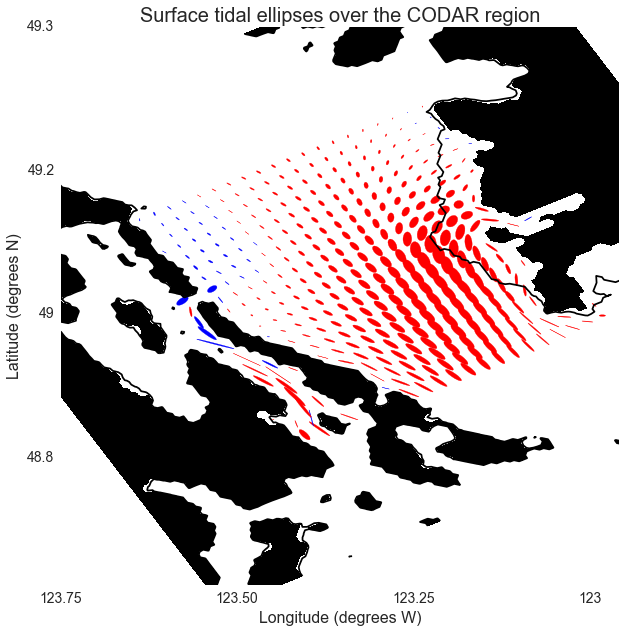

In [8]:
phi = 29
fig, ax = plt.subplots(1, 1, figsize=(10,10))
k = np.zeros((898, 398))
m = np.zeros((898, 398))
scale = 10
ex=40

for q in np.arange(jmin-ex, jmax+ex):
    for l in np.arange(imin-ex, imax+ex):
        k[q, l] = q * np.cos(phi*np.pi/180.)+l*np.sin(phi*np.pi/180.)
        m[q, l] = -q * np.sin(phi*np.pi/180.)+l*np.cos(phi*np.pi/180.)

for x in np.arange(imin, imax, 4):
    for y in np.arange(jmin, jmax, 4):
        if params_av[y, x, 1] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ellsc = Ellipse(
            xy=(m[y, x], k[y, x]),
            width=scale * params_av[y, x, 0],
            height=scale * params_av[y, x, 1],
            angle=params_av[y, x, 2],
            color=thec)
        ax.add_artist(ellsc)

grid_B = nc.Dataset(
    '/data/dlatorne/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy = grid_B.variables['Bathymetry'][:, :]

contour_interval = [-0.01, 0.01]
ax.contourf(m[jmin-ex:jmax+ex, imin-ex:imax+ex],
            k[jmin-ex:jmax+ex, imin-ex:imax+ex],
            bathy.data[jmin-ex:jmax+ex, imin-ex:imax+ex],
            contour_interval,
            colors='black')
ax.contour(m[jmin-ex:jmax+ex, imin-ex:imax+ex],
           k[jmin-ex:jmax+ex, imin-ex:imax+ex],
           bathy.data[jmin-ex:jmax+ex, imin-ex:imax+ex],
           [5],
           colors='black')


ax.set_ylim([399, 421])
slope = (lats[jmax,imax]-lats[jmin,imin])/(k[jmax,imax]-k[jmin,imin])
mylist = (k[jmax,imax]+(np.arange(48.3, 49.05, 0.2)-
                           lats[jmin,imin])/slope).tolist()
labels = ['48.8', '49', '49.2', '49.3']
ax.set_yticks(mylist)
ax.set_yticklabels(labels)
ax.set_ylabel('Latitude (degrees N)', **axisfont)
# x-axis in m, but labelled in longitude
ax.set_xlim([0,100])
slope = (lons[jmax,imax]-lons[jmin,imin])/(m[jmax,imax]-m[jmin,imin])
mylist = (m[jmax,imax]+(np.arange(-123.86,-123.2,0.2)-
                        lons[jmin,imin])/slope).tolist()
labels = ['123.75', '123.50', '123.25', '123']
ax.set_xticks(mylist)
ax.set_xticklabels(labels)
ax.set_xlabel('Longitude (degrees W)', **axisfont)

ax.set_title('Surface tidal ellipses over the CODAR region', **font)
ax.tick_params(axis='both', which='major', labelsize=14)
print 'red is clockwise'
print m.shape

#Phase plot

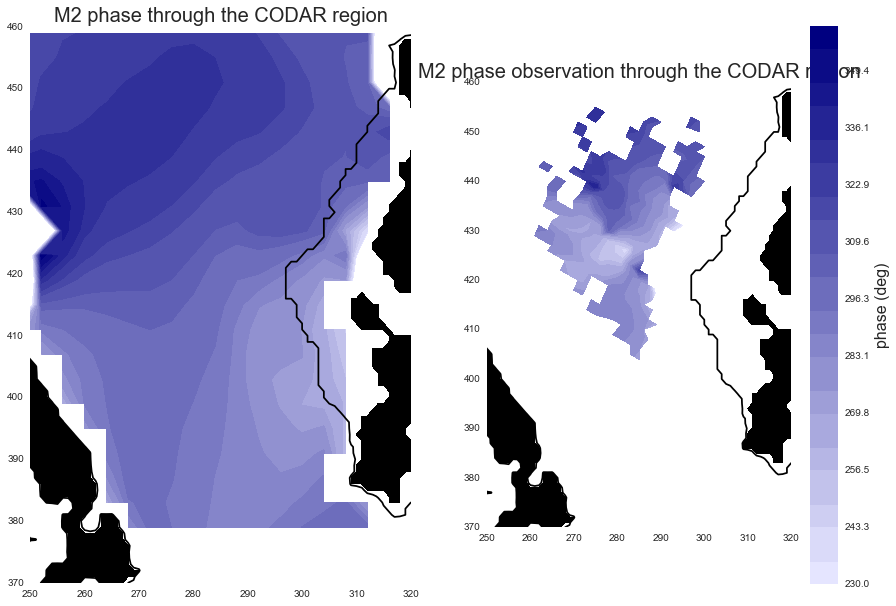

In [263]:
jmin = 379; jmax = 461; imin = 236; imax=321 
ex=30
q = np.arange(jmin-ex,jmax+ex)
l = np.arange(imin-ex,imax+ex)
k,m = np.meshgrid(q,l)

vals = params_av[jmin:jmax:4, imin:imax:4, 3]
valsk1 = params_av[jmin:jmax:4, imin:imax:4, 7]
x = np.arange(imin,imax,4)
y = np.arange(jmin, jmax,4)

vs= np.linspace(230,360)
#vs = np.linspace(0,360)
#palette = sns.hls_palette(35, l=.6, s=0.9)
palette = sns.cubehelix_palette(18, start=.5, rot=-.75)
palette = sns.light_palette("navy" , 20)
cmap1 = mcolors.ListedColormap(palette)


fig, [ax, ax1] = plt.subplots(1,2, figsize=(15,10))
#Model

mesh = ax.contourf(x, y, vals, vs, cmap=cmap1)
contour_interval = [-0.01, 0.01]
ax.contourf(m,k,
        bathy.data[k, m],contour_interval,colors='black')
ax.contour(m, k,
            bathy.data[k,m],[5],colors='black')
viz_tools.set_aspect(ax)
ax.set_ylim([370, 460])
ax.set_xlim([250, 320])
ax.set_title('M2 phase through the CODAR region', **font)

#Observations
cbar = plt.colorbar
mesh = ax1.contourf(iss, jss, phaM2, vs, cmap=cmap1)
cbar = fig.colorbar(mesh)
contour_interval = [-0.01, 0.01]
ax1.contourf(m,k, bathy.data[k, m],contour_interval,colors='black')
ax1.contour(m, k, bathy.data[k,m],[5],colors='black')
ax1.set_ylim([370, 460])
ax1.set_xlim([250, 320])
viz_tools.set_aspect(ax1)
cbar.set_label('phase (deg)',**axisfont)
ax1.set_title('M2 phase observation through the CODAR region',**font)

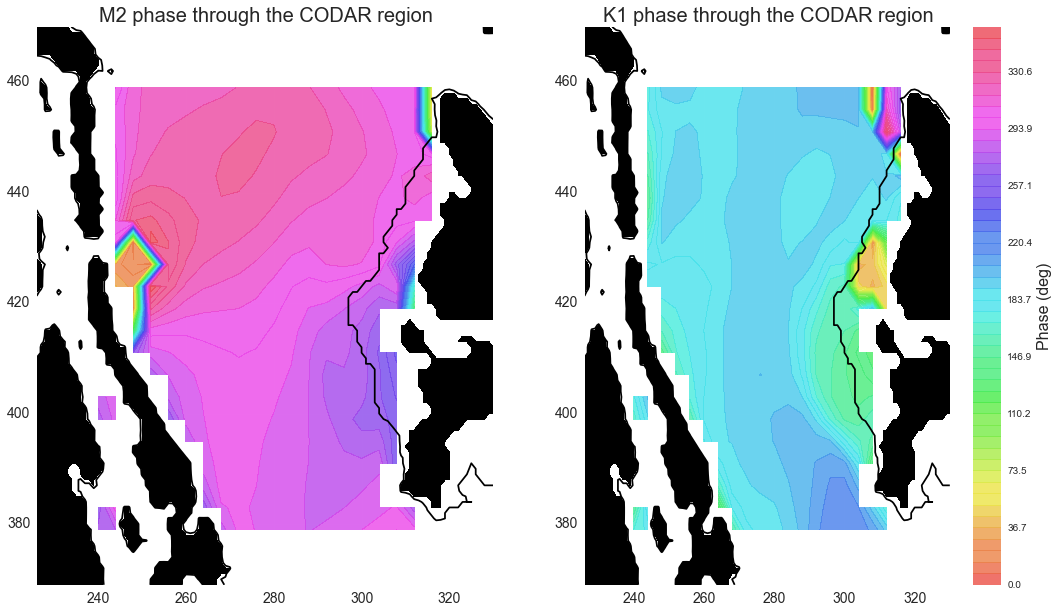

In [264]:
ex=10
q = np.arange(jmin-ex,jmax+ex)
l = np.arange(imin-ex,imax+ex)
k,m = np.meshgrid(q,l)
vals = params_av[jmin:jmax:4, imin:imax:4, 3]
x = np.arange(imin,imax,4)
y = np.arange(jmin, jmax,4)

vs = np.linspace(0,360)
vs1 = np.arange(290,360,8)
vs2 = np.linspace(170,270, 8)
palette = sns.hls_palette(40, l=.6, s=0.8)
cmap1 = mcolors.ListedColormap(palette)


fig, (ax, ax1) = plt.subplots(1,2, figsize=(18,10))


cbar = plt.colorbar
mesh = ax.contourf(x, y, vals, vs, cmap=cmap1, alpha = 0.80)
cbar = fig.colorbar(mesh)
contour_interval = [-0.01, 0.01]
ax.contourf(m,k,bathy.data[k, m],contour_interval,colors='black')
ax.contour(m, k,bathy.data[k,m],[5],colors='black')
cbar.set_label('Phase (deg)',**axisfont)
ax.set_title('M2 phase through the CODAR region',**font)
ax.tick_params(axis='both', which='major', labelsize=14)

mesh = ax1.contourf(x, y, valsk1, vs, cmap=cmap1, alpha = 0.8)
contour_interval = [-0.01, 0.01]
ax1.contourf(m,k,bathy.data[k, m],contour_interval,colors='black')
ax1.contour(m, k,bathy.data[k,m],[5],colors='black')
ax1.set_title('K1 phase through the CODAR region', **font)
ax1.tick_params(axis='both', which='major', labelsize=14)

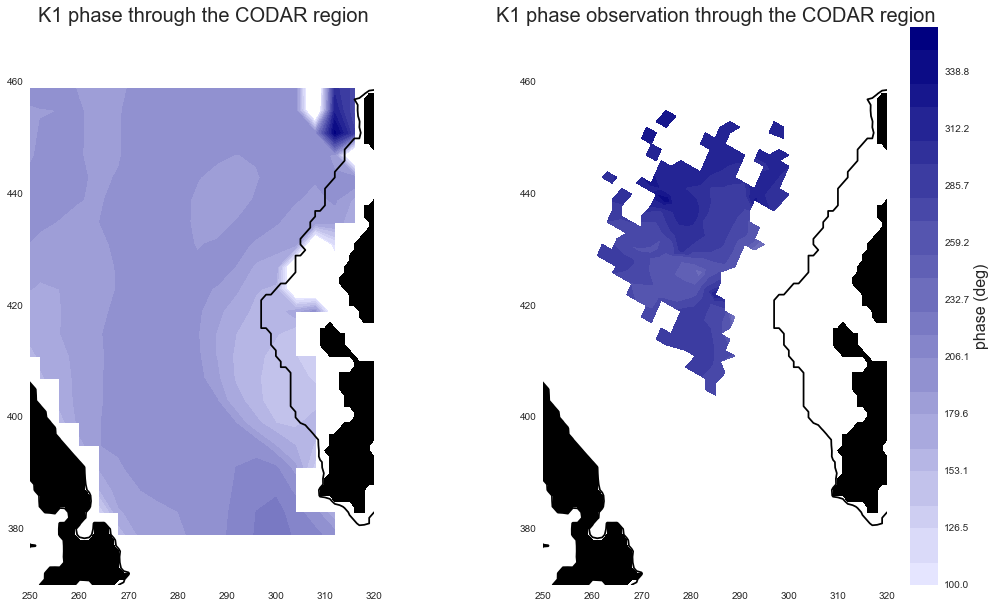

In [262]:
ex=10
q = np.arange(jmin-ex,jmax+ex)
l = np.arange(imin-ex,imax+ex)
k,m = np.meshgrid(q,l)

vals = params_av[jmin:jmax:4, imin:imax:4, 7]
x = np.arange(imin,imax,4)
y = np.arange(jmin, jmax,4)

vs = np.linspace(100,360)
palette = sns.light_palette("navy" , 20)
cmap1 = mcolors.ListedColormap(palette)


fig, [ax, ax1] = plt.subplots(1,2, figsize=(18,10))
#Model
mesh = ax.contourf(x, y, vals, vs, cmap=cmap1)
contour_interval = [-0.01, 0.01]
ax.contourf(m,k,
        bathy.data[k, m],contour_interval,colors='black')
ax.contour(m, k,
            bathy.data[k,m],[5],colors='black')
viz_tools.set_aspect(ax)
ax.set_ylim([370, 470])
ax.set_xlim([250, 320])
ax.set_title('K1 phase through the CODAR region',**font)

#Observations
cbar = plt.colorbar
mesh = ax1.contourf(iss, jss, phaK1, vs, cmap=cmap1)
cbar = fig.colorbar(mesh)
contour_interval = [-0.01, 0.01]
ax1.contourf(m,k, bathy.data[k, m],contour_interval,colors='black')
ax1.contour(m, k, bathy.data[k,m],[5],colors='black')
viz_tools.set_aspect(ax1)
ax1.set_ylim([370, 470])
ax1.set_xlim([250, 320])
cbar.set_label('phase (deg)',**axisfont)
ax1.set_title('K1 phase observation through the CODAR region',**font)